In [1]:
!pip install matplotlib --upgrade
!pip install nibabel --upgrade
!pip install nilearn
import os
import numpy as np
from scipy import io as sio
from scipy import stats as stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Mount Google drive

In [2]:
# Mount your Google drive to the Google colab notebook 
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/KNU_2023_FC_classification')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load fMRI timeseries

In [3]:
# Resting-state (time x ROIs)
fMRI_data_rest = sio.loadmat("fMRI_timeseries_rest.mat")
print(np.shape(fMRI_data_rest['x']))
fMRI_std_rest = np.std(fMRI_data_rest['x'],axis=0)
print(np.shape(fMRI_std_rest))

# Working memory task (time x ROIs)
fMRI_data_task = sio.loadmat("fMRI_timeseries_task.mat")
print(np.shape(fMRI_data_task['x']))
fMRI_std_task = np.std(fMRI_data_task['x'],axis=0)
print(np.shape(fMRI_std_task))

(1200, 200)
(200,)
(405, 200)
(200,)


# Check fMRI data on 3D brain space

In [4]:
import nibabel as nib
from nilearn import datasets
from nilearn import plotting
from nilearn import image

n_rois = 200

atlas_img = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, yeo_networks=7, resolution_mm=2)
atlas = image.load_img(atlas_img['maps'])
atlas_data = atlas.get_fdata()
coordinate = plotting.find_parcellation_cut_coords(atlas_img['maps'])

roi_info = pd.read_table('atlas_info.txt',names=['roi','name','R','G','B',' '])
roi_RGB = np.vstack([roi_info['R'].to_numpy(),roi_info['G'].to_numpy(),roi_info['B'].to_numpy()]).T/255


Dataset created in /root/nilearn_data/schaefer_2018



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


In [6]:
rest_3d = np.zeros(atlas_data.shape, dtype=np.float32)
for i,n in enumerate(range(n_rois)):
    rest_3d[atlas_data==n+1] = fMRI_std_rest[i]
rest_3d_img = nib.Nifti1Image(rest_3d, atlas.affine, atlas.header) 
plotting.view_img_on_surf(rest_3d_img, threshold='90%', surf_mesh='fsaverage5', title="[Resting-state] STD across time")  

Output hidden; open in https://colab.research.google.com to view.

In [7]:
task_3d = np.zeros(atlas_data.shape, dtype=np.float32)
for i,n in enumerate(range(n_rois)):
    task_3d[atlas_data==n+1] = fMRI_std_task[i]
task_3d_img = nib.Nifti1Image(task_3d, atlas.affine, atlas.header) 
plotting.view_img_on_surf(task_3d_img, threshold='90%', surf_mesh='fsaverage5', title="[Working memory task] STD across time") 

Output hidden; open in https://colab.research.google.com to view.

# Calculate task FC based on the task timing info

In [9]:
TR = 0.72
start_vol, end_vol = 118, 151
duration = end_vol-start_vol+1
duration_s = duration*TR
print("Duration: {} volumes = {} s".format(duration,duration_s))

Duration: 34 volumes = 24.48 s


In [10]:
fMRI_task_select = fMRI_data_task['x'][start_vol:(end_vol+1)]
print(np.shape(fMRI_task_select))

# Calculate FC within task block
FC_task = np.corrcoef(fMRI_task_select.T)
print(np.shape(FC_task))

(34, 200)
(200, 200)


(19900,)
(200, 200)


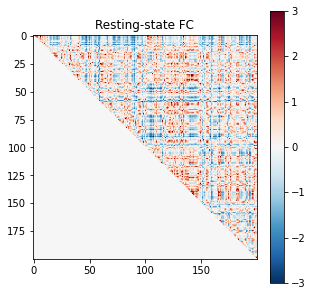

In [14]:
# 2D to 1D & r to z 
triu_ind = np.triu_indices(n_rois,k=1)
FC_task_vec = FC_task[triu_ind]
FC_task_vec_z = np.arctanh(FC_task_vec)
FC_task_vec_z = stats.zscore(FC_task_vec_z)
print(np.shape(FC_task_vec_z))

# Back to 2D
FC_task_z = np.zeros((n_rois,n_rois))
FC_task_z[triu_ind] = FC_task_vec_z
print(np.shape(FC_task_z))

plt.figure(figsize=(5,5))
plt.imshow(FC_task_z, vmin=-3, vmax=3, cmap='RdBu_r')
plt.title('Resting-state FC')
plt.colorbar()
plt.show()

# Calculate resting-state FC using temporal window

In [13]:
scan_len = np.size(fMRI_data_rest['x'],axis=0)
window_len = 42
window_len_s = window_len*TR
n_steps = scan_len//window_len
print("window: {} volumes = {} s".format(window_len,window_len_s))

window: 42 volumes = 30.24 s


(28, 200, 200)


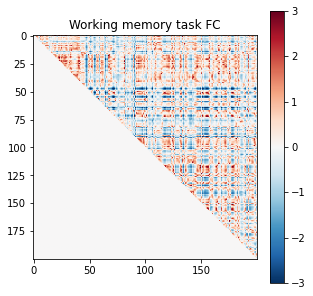

In [15]:
FC_rest_z = np.zeros((n_steps,n_rois,n_rois))
for step in range(n_steps):
    start_vol = step*window_len
    end_vol = (step+1)*window_len-1
    fMRI_rest_select = fMRI_data_rest['x'][start_vol:(end_vol+1)]
    
    # Calculate FC within window
    FC_rest = np.corrcoef(fMRI_rest_select.T)
    
    # 2D to 1D & r to z 
    FC_rest_vec = FC_rest[triu_ind]
    FC_rest_vec_z = np.arctanh(FC_rest_vec)
    FC_rest_vec_z = stats.zscore(FC_rest_vec_z)
    
    # Back to 2D
    FC_rest_z[step,triu_ind[0],triu_ind[1]] = FC_rest_vec_z
    
print(np.shape(FC_rest_z))

plt.figure(figsize=(5,5))
plt.imshow(FC_rest_z[0,:,:], vmin=-3, vmax=3, cmap='RdBu_r')
plt.title('Working memory task FC')
plt.colorbar()
plt.show()